# 1. import needed package

In [2]:
from mxnet import autograd
from mxnet import gluon
from mxnet import image
from mxnet import init
from mxnet import nd
from mxnet.gluon.model_zoo import vision as model
from mxnet.gluon import nn
from mxnet.gluon.data import vision
import numpy as np
import mxnet as mx
import sys
sys.path.insert(0, '../../utils')
from dataset import *
from netlib import *
from backgrad_utils import *
import os
import shutil
from cifar10_utils import show_images, parse_log, show_log, update
import utils
from mxnet.gluon.data.dataset import ArrayDataset
import pandas as pd

ctx = mx.gpu(0)
arrayds_dir = '/home/hui/dataset/CIFAR10/arraydataset/'

def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))

# 2. data loader, data argument

In [3]:
"""
data loader
"""
def _transform_test(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1))
    return im, nd.array([label]).astype('float32')

"""
data argument
"""
def transform_train_DA1(data, label):
    im = data.asnumpy()
    im = np.pad(im, ((4, 4), (4, 4), (0, 0)), mode='constant', constant_values=0)
    im = nd.array(im, dtype='float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, rand_mirror=True,
                                    rand_crop=True,
                                   mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1)) # channel x width x height
    return im, nd.array([label]).astype('float32')


def load_all_data_label(pathes):
    all_data, all_label = None, None
    for path in pathes:
        data, label = nd.load(path)
        label = label.reshape((-1,)).astype('float32')
        if all_data is None:
            all_data, all_label = data, label
        else:
            all_data = nd.concat(all_data, data, dim=0)
            all_label = nd.concat(all_label, label, dim=0)
    return all_data, all_label


def data_loader2(batch_size=[128, 128, 128], transform=[_transform_test, transform_train_DA1, _transform_test], num_workers=[1, 2, 2], origin_shuffle=False):
    origin_data_array, origin_label_array = load_all_data_label([arrayds_dir + 'origin.ndarray'])
    origin_ds = MyArrayDataset2([origin_data_array, origin_label_array], transform=transform[0])
    origin_data = gluon.data.DataLoader(origin_ds, batch_size[0], shuffle=origin_shuffle, last_batch='keep', num_workers=num_workers[0])
    
    datas = [[origin_data_array, origin_data_array.copy()], [origin_label_array, origin_label_array.copy()]]
    train_ds = MyArrayDataset2(datas, transform=transform[1])
    train_data = gluon.data.DataLoader(train_ds, batch_size[1], shuffle=True, last_batch='keep', num_workers=num_workers[1])
    
    test_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=False, transform=transform[2])
    test_data = gluon.data.DataLoader(test_ds, batch_size[2], shuffle=False, last_batch='keep', num_workers=num_workers[2])
    return (origin_data, train_data, test_data), (origin_ds, train_ds, test_ds)

# 3 data aurgument: mixup
1. mixup define
2. mixup visualize

In [4]:
import numpy as np
def mixup(x1, y1, x2, y2, alpha, num_class):
    y1 = nd.one_hot(y1, num_class)
    y2 = nd.one_hot(y2, num_class)
    
    lam = np.random.beta(alpha, alpha)
    x = lam * x1 + (1 - lam) * x2
    y = lam * y1 + (1 - lam) * y2
    return x, y

# 3. data augment: back grad

## 3.1 define a simple back grad method

In [5]:
from cifar10_utils import show_images
import utils
import os, shutil
%matplotlib inline

EPS = 1e-30

def show_data(data, clip=True):
    images = inv_normalize(data, clip=clip)
    show_images(images)
    
def get_soft_label(y, num_class, soft_label_th):
    y = y.reshape((-1,))
    ny = (y.one_hot(num_class) + soft_label_th / num_class)
    y = y.asnumpy()
    ny[range(y.shape[0]), y.astype('int32')] -= soft_label_th
    return nd.array(ny)
   
def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))
    
def statistic(diffs):
    t = np.mean(diffs), np.max(diffs), np.min(diffs), np.std(diffs)
    return t
    
def inv_normalize(data, mean=None, std=None, clip=True, asnumpy=True):
    if mean is None: mean=nd.array([0.4914, 0.4822, 0.4465])
    if std is None: std=nd.array([0.2023, 0.1994, 0.2010])
    if asnumpy: 
        data, mean, std = data.asnumpy(), mean.asnumpy(), std.asnumpy()
    images = data.transpose((0, 2, 3, 1))
    images = images * std + mean
    images = images.transpose((0, 3, 1, 2)) * 255
    if clip: 
        images = images.clip(0, 255)
    return images


class BackGradDataGenerator:
    """
        just a set of many static function
    """
    # 2. function to generate back_grad data
    
    @staticmethod
    def SGD(data, lr):
        # print nd.mean(data.grad).asscalar()
        data[:, :, :, :] = data - data.grad * lr
    
    @staticmethod
    def generate_backgrad_data(net, data, label, max_iters=60, lr=0.1, iter_log=False, clip=False, 
                               loss_f=gluon.loss.SoftmaxCrossEntropyLoss(), bn_control=None):
        """
            data is better in cpu, if data in ctx(global var), the returned backgrad_data is shallow copy of data.
        """
        context = data.context
#         if str(context)[:3] != "cpu":
#             print "warring: data was not in CPU, the returned backgrad_data is shallow copy of data."
        if bn_control is not None:
            bn_control.store()

        data, label = data.as_in_context(ctx), label.as_in_context(ctx)
        for iters in range(1, max_iters+1):
            with autograd.record():
                data.attach_grad()
                output = net(data)
                loss = -loss_f(output, label)
            loss.backward()
            mean_loss = nd.mean(loss).asscalar()     # reduce will make memory release

            if iter_log and iters % 50 == 0:
                show_data(data[:5], clip)
                #print data[0, 0, :2, :10]
                #print data.grad[0, 0, :2, :10]
            if iter_log and iters % 5 == 0:
                print 'iter:', iters, 'loss:', mean_loss

            BackGradDataGenerator.SGD(data, lr)
        if bn_control is not None:
            bn_control.load()
            
        return data.as_in_context(context), (loss.as_in_context(context), mean_loss, )
    
    @staticmethod
    def MSE_constraint(mse, same_rate=False):
        def constraint(backgrad_data, data, diff, _loss, MSE, SNR):
            if same_rate:
                rate = nd.mean(nd.sqrt(mse / MSE))
                backgrad_data[:, :, :, :] = data + ((backgrad_data - data) * rate)
            else:
                backgrad_data[:, :, :, :] = data + ((backgrad_data - data).transpose((1, 2, 3, 0))
                                                * (nd.sqrt(mse / MSE))).transpose((3, 0, 1, 2))
        return constraint
    
    @staticmethod
    def generate_backgrad_data_constraint(net, data, label, max_iters=60, lr=0.1, iter_log=False, clip=False, 
                               loss_f=gluon.loss.SoftmaxCrossEntropyLoss(), bn_control=None, post_deal=None):
        backgrad_data, (_loss, _bloss, ) = BackGradDataGenerator.generate_backgrad_data(net, data.as_in_context(mx.cpu()), label, 
                                                                max_iters, lr, iter_log, clip, loss_f, bn_control)
        
        if post_deal is not None:
            tmp = (backgrad_data - data) ** 2
            diff = nd.sqrt(nd.sum(tmp, axis=0, exclude=True))
            MSE = nd.mean(tmp, axis=0, exclude=True)
            Savg = nd.mean((data) ** 2, axis=0, exclude=True)
            # SNR = 10 * nd.log10(Savg / (MSE))
            SNR = 10 * nd.log10(Savg / (MSE + EPS))
            post_deal(backgrad_data, data, diff, _loss, MSE, SNR)
        return backgrad_data, (_loss, _bloss, ) 
            
    @staticmethod
    def generate_data_for_out(net, origin_data, max_iters=10, lr=0.1,
                            use_batch_mean_std=False, use_statistic=True, show_per_iters=None,
                            loss_f = gluon.loss.SoftmaxCrossEntropyLoss(), out_data=None, begin_index=0, 
                            bn_control=None, post_deal=None):
        out_idx, iters = begin_index, 0
        diffs, losses, MSEs, SNRs, bloss = None, None, None, None, 0
        
        if bn_control is None:
            bn_backup = BNControl(net.net, use_batch_mean_std) # to avoid update moving_mean/std when generate image
            bn_backup.store()
        for data, label in origin_data:
            backgrad_data, (_loss, _bloss, ) = BackGradDataGenerator.generate_backgrad_data_constraint(
                net, data, label, max_iters=max_iters, lr=lr, iter_log=False, clip=False, loss_f=loss_f, 
                bn_control=bn_control, post_deal=post_deal)
            
            tmp = (backgrad_data - data) ** 2
            diff = nd.sqrt(nd.sum(tmp, axis=0, exclude=True))
            MSE = nd.mean(tmp, axis=0, exclude=True)
            Savg = nd.mean((data) ** 2, axis=0, exclude=True)
            # SNR = 10 * nd.log10(Savg / (MSE))
            SNR = 10 * nd.log10(Savg / (MSE + EPS))
            bloss += _bloss

            if diffs is None: 
                diffs, losses, MSEs, SNRs = diff, _loss, MSE, SNR
            else:
                diffs, losses = nd.concat(diffs, diff, dim=0), nd.concat(losses, _loss, dim=0)
                MSEs, SNRs = nd.concat(MSEs, MSE, dim=0), nd.concat(SNRs, SNR, dim=0)
                
            # must copy to cpu, or will make gpu memory leak(not release)
            backgrad_data = inv_normalize(backgrad_data, clip=False, asnumpy=False)
            out_data[out_idx:out_idx+data.shape[0], :, :, :] = backgrad_data.transpose((0, 2, 3, 1)).as_in_context(mx.cpu())
            out_idx += data.shape[0]
                    
            if show_per_iters is not None and iters % show_per_iters == 0:
                show_images(inv_normalize(data[np.array(range(0, 25, 5)) % data.shape[0]], clip=False))
                show_images(backgrad_data[np.array(range(0, 25, 5)) % data.shape[0]].asnumpy())
            iters += 1
        if bn_control is None:
            bn_backup.load()
        
        diffs, losses, MSEs, SNRs = diffs.asnumpy(), losses.asnumpy(), MSEs.asnumpy(), SNRs.asnumpy()
        if use_statistic:
            return statistic(diffs), statistic(losses), statistic(MSEs), statistic(SNRs)
        else:
            return diffs, losses, MSEs, SNRs    
        
BGG = BackGradDataGenerator

load data
accuracy: 1.0


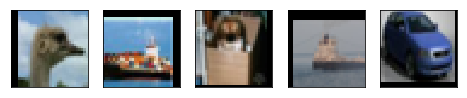

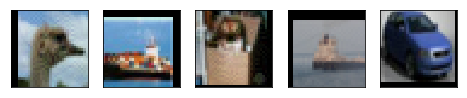

0.00187629 0.0173296 8.12029e-05 0.00300552


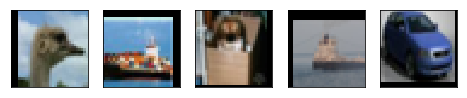

0.003 0.003 0.003 5.59066e-10


In [5]:
import random
try:
    origin_data_array
except BaseException:
    print "load data"
    origin_data_array, origin_label_array = load_all_data_label([arrayds_dir + 'origin.ndarray'])

def test(origin_data_array, origin_label_array, shuffle=True):
    indices = range(0, 50000)
    if shuffle: 
        random.shuffle(indices)
    indices = nd.array(indices[:256])
    origin_data_array, origin_label_array = origin_data_array.take(indices), origin_label_array.take(indices)
    origin_ds = MyArrayDataset2([origin_data_array, origin_label_array], transform=transform_train_DA1)#_transform_test)
    origin_data = gluon.data.DataLoader(origin_ds, 128, shuffle=False, num_workers=0)
    
    datas = [[origin_data_array, origin_data_array.copy()], [origin_label_array, origin_label_array.copy()]]
    train_ds = MyArrayDataset2(datas, transform=_transform_test)
    train_data = gluon.data.DataLoader(train_ds, 128, shuffle=False, num_workers=2)
    
    net = ResNet(10)
    #net.initialize(ctx=ctx)
    #net.load_params('../../models/resnet18_me_backgrad_prob_online_iter10_lr01', ctx=ctx)
    net.load_params('../../models/resnet18_me_200e', ctx=ctx)
    print "accuracy:", utils.evaluate_accuracy(train_data, net, ctx)
    
    for data, label in origin_data:
        break
    show_data(data[:5], clip=False)
    
    bn_control = BNControl(net.net, True)
    constraint = None#BGG.MSE_constraint(0.003)
    backgrad_data, _ = BGG.generate_backgrad_data(net,
                data, label, max_iters=10, lr=0.1, bn_control=bn_control)
    tmp = (backgrad_data - data) ** 2
    diff = nd.sqrt(nd.sum(tmp, axis=0, exclude=True))
    MSE = nd.mean(tmp, axis=0, exclude=True).asnumpy()
    show_data(backgrad_data[:5], clip=False)
    print np.mean(MSE), np.max(MSE), np.min(MSE), np.std(MSE)
    
    constraint = BGG.MSE_constraint(0.003)
    backgrad_data, _ = BGG.generate_backgrad_data_constraint(net,
                data, label, max_iters=10, lr=0.1, bn_control=bn_control, post_deal=constraint)
    tmp = (backgrad_data - data) ** 2
    diff = nd.sqrt(nd.sum(tmp, axis=0, exclude=True))
    MSE = nd.mean(tmp, axis=0, exclude=True).asnumpy()
    show_data(data[:5], clip=False)
    print np.mean(MSE), np.max(MSE), np.min(MSE), np.std(MSE)
    
    
test(origin_data_array, origin_label_array, True)

# 4. analysis

## 4.1 only use 128 images to simple test
loss != -acc != -MSE

In [5]:
import random

try:
    origin_data_array
except:
    origin_data_array, origin_label_array = load_all_data_label([arrayds_dir + 'origin.ndarray'])

def test(generate_net, test_net, origin_data_array, origin_label_array, 
         shuffle=True, transform=_transform_test, constraint=None):
    indices = range(0, 50000); 
    if shuffle: 
        random.shuffle(indices); 
    indices = nd.array(indices[:128])
    origin_data_array, origin_label_array = origin_data_array.take(indices), origin_label_array.take(indices)
    origin_ds = MyArrayDataset2([origin_data_array, origin_label_array], transform=transform)#_transform_test)
    origin_data = gluon.data.DataLoader(origin_ds, 128, shuffle=False, num_workers=0)
    
    datas = [[origin_data_array, origin_data_array.copy()], [origin_label_array, origin_label_array.copy()]]
    train_ds = MyArrayDataset2(datas, transform=transform)
    train_data = gluon.data.DataLoader(train_ds, 128, shuffle=True, num_workers=2)
    
    net = ResNet(10)
    if generate_net == "random init":
        net.initialize(ctx=ctx)
    else:
        net.load_params("../../models/" + generate_net, ctx=ctx)
    utils.evaluate_accuracy(train_data, net, ctx)
    
    xs = BGG.generate_data_for_out(net, origin_data, max_iters=10, lr=0.1,use_batch_mean_std=True, use_statistic=True, show_per_iters=None,
                                loss_f = gluon.loss.SoftmaxCrossEntropyLoss(), out_data=train_ds._data[0][1], begin_index=0,
                                  post_deal=constraint)
    
    net.load_params("../../models/" + test_net, ctx=ctx)
    acc = utils.evaluate_accuracy(train_data, net, ctx)
    return xs, acc
 
constraint = BGG.MSE_constraint(0.003)
nets = ['random init', 'resnet18_me_200e', 'resnet18_me_backgrad_prob_online_iter10_lr01',
       'train8_resnet18_r1_i10_lr01_bT', 'train8_resnet18_r1_i10_lr01_bT_prob']

In [6]:
def ex_test(constraint, shuffle, transform):
    global acc_df, xs_df, index
    xs, acc = {}, {}
    for tn in nets[1:]:
        k_tn = tn.replace('_', ' ')
        xs[k_tn], acc[k_tn] = {}, {}
        for gn in nets:
            k_gn = gn.replace('_', ' ')
            xs[k_tn][k_gn], acc[k_tn][k_gn] = test(gn, tn, origin_data_array, origin_label_array,
                                                   shuffle, transform, constraint)
    acc_df.append(pd.DataFrame(data=acc))
    xs_df.append(pd.DataFrame(data=xs))
    
acc_df, xs_df = [], []
ex_test(None, shuffle=True, transform=_transform_test)
ex_test(None, shuffle=False, transform=_transform_test)
ex_test(constraint, shuffle=True, transform=_transform_test)
ex_test(constraint, shuffle=False, transform=_transform_test)
ex_test(constraint, shuffle=True, transform=transform_train_DA1)
ex_test(constraint, shuffle=False, transform=transform_train_DA1)

v_idx = {'diff': 0, 'loss': 1, 'MSE': 2, 'SNR': 3}

In [60]:
def get_xs(id1, var, id2):
    return pd.DataFrame([[v[v_idx[var]][id2] for v in line] for line in xs_df[id1].values]
             , index=[n.replace("_", ' ') for n in nets])

## 4.1
```
1.1 resnet18_me_200e has higgest loss and valid error
1.2 no_prob_bT net has higgher loss and valid error than prob_BT_net
1.3 online_net is almost same as prob_BT, means code is no bugs.
1.4 shuffle=False can get higger loss and MSE, but no higger valid error.
1.5 MSE_contract have some effect to valid error
```

### 4.1.1 simple analysis

In [129]:
xs, acc = {}, {}
for tn in nets[1:]:
    k_tn = tn.replace('_', ' ')
    xs[k_tn], acc[k_tn] = {}, {}
    for gn in nets:
        k_gn = gn.replace('_', ' ')
        xs[k_tn][k_gn], acc[k_tn][k_gn] = test(gn, tn, origin_data_array, origin_label_array,
                            shuffle=True, transform=transform_train_DA1, constraint=None)
acc = pd.DataFrame(acc)
xs = pd.DataFrame(xs)

In [130]:
-pd.DataFrame([[v[v_idx['loss']][0] for v in line] for line in xs.values]
             , index=[n.replace("_", ' ') for n in nets])

,0,1,2,3
random init,2.560220,2.592990,2.629665,2.810320
resnet18 me 200e,11.448834,7.487314,6.353068,6.329889
resnet18 me backgrad prob online iter10 lr01,0.006155,0.033490,0.002326,0.005859
train8 resnet18 r1 i10 lr01 bT,1.175085,0.444040,0.616724,0.124734
train8 resnet18 r1 i10 lr01 bT prob,0.003258,0.004517,0.073248,0.004162


In [138]:
(1-acc.T) * 100 * 2 # train_data contain origin data

,random init,resnet18 me 200e,resnet18 me backgrad prob online iter10 lr01,train8 resnet18 r1 i10 lr01 bT,train8 resnet18 r1 i10 lr01 bT prob
resnet18 me 200e,1.56250,47.65625,0.78125,4.6875,0.0000
resnet18 me backgrad prob online iter10 lr01,0.78125,4.68750,1.56250,3.1250,0.0000
train8 resnet18 r1 i10 lr01 bT,2.34375,3.12500,2.34375,6.2500,3.1250
train8 resnet18 r1 i10 lr01 bT prob,0.00000,3.12500,0.78125,1.5625,1.5625


### 4.1.2 shufle=False get higger loss and MSE but no higger valid error
(attention shuffle here is in random choose data, not just batch shuffle)<br/>
maybe shuffle=False got lower batch std in generation, then when backword, y=(x-m)/s get grad dy/dx=1/s, get higger grad, so same as higger lr used, (MSE is grad square sum, it is also higger cna prove it.)

In [132]:
get_xs(0, 'loss', 0)  # ex_test(None, shuffle=True, transform=_transform_test)

,0,1,2,3
random init,-2.769139,-2.808163,-2.651265,-2.800403
resnet18 me 200e,-15.427659,-16.601934,-12.389709,-13.635384
resnet18 me backgrad prob online iter10 lr01,-0.349483,-0.941743,-0.563564,-0.944525
train8 resnet18 r1 i10 lr01 bT,-2.465200,-1.603663,-2.369197,-1.578181
train8 resnet18 r1 i10 lr01 bT prob,-0.578556,-0.641272,-0.432860,-0.304091


In [133]:
get_xs(1, 'loss', 0)  # ex_test(None, shuffle=False, transform=_transform_test)

,0,1,2,3
random init,-2.168510,-1.764615,-2.519436,-2.274912
resnet18 me 200e,-20.687374,-20.681044,-20.675507,-20.681196
resnet18 me backgrad prob online iter10 lr01,-10.410021,-10.410123,-10.410310,-10.409928
train8 resnet18 r1 i10 lr01 bT,-14.379402,-14.379636,-14.379740,-14.379580
train8 resnet18 r1 i10 lr01 bT prob,-10.502854,-10.502912,-10.502899,-10.502812


In [139]:
(1-acc_df[0].T) * 100 * 2 # ex_test(None, shuffle=True, transform=_transform_test)

,random init,resnet18 me 200e,resnet18 me backgrad prob online iter10 lr01,train8 resnet18 r1 i10 lr01 bT,train8 resnet18 r1 i10 lr01 bT prob
resnet18 me 200e,0.0,69.53125,0.78125,6.25000,2.34375
resnet18 me backgrad prob online iter10 lr01,0.0,0.00000,5.46875,0.78125,0.78125
train8 resnet18 r1 i10 lr01 bT,0.0,3.12500,0.00000,10.15625,0.78125
train8 resnet18 r1 i10 lr01 bT prob,0.0,3.12500,1.56250,2.34375,0.78125


In [140]:
(1-acc_df[1].T) * 100 * 2# ex_test(None, shuffle=False, transform=_transform_test)

,random init,resnet18 me 200e,resnet18 me backgrad prob online iter10 lr01,train8 resnet18 r1 i10 lr01 bT,train8 resnet18 r1 i10 lr01 bT prob
resnet18 me 200e,0.0,67.96875,6.2500,6.25000,3.90625
resnet18 me backgrad prob online iter10 lr01,0.0,0.00000,1.5625,0.78125,0.00000
train8 resnet18 r1 i10 lr01 bT,0.0,0.78125,0.0000,5.46875,0.78125
train8 resnet18 r1 i10 lr01 bT prob,0.0,0.00000,0.0000,0.00000,0.78125


### 4.1.3 higger MSE not mean get harder example, but also get some effect

In [142]:
(acc_df[2].T-acc_df[0].T) * 100
(acc_df[3].T-acc_df[1].T) * 100
(1-acc_df[0].T) * 100 * 2

,random init,resnet18 me 200e,resnet18 me backgrad prob online iter10 lr01,train8 resnet18 r1 i10 lr01 bT,train8 resnet18 r1 i10 lr01 bT prob
resnet18 me 200e,0.0,69.53125,0.78125,6.25000,2.34375
resnet18 me backgrad prob online iter10 lr01,0.0,0.00000,5.46875,0.78125,0.78125
train8 resnet18 r1 i10 lr01 bT,0.0,3.12500,0.00000,10.15625,0.78125
train8 resnet18 r1 i10 lr01 bT prob,0.0,3.12500,1.56250,2.34375,0.78125


In [143]:
(1-acc_df[2].T) * 100 * 2

,random init,resnet18 me 200e,resnet18 me backgrad prob online iter10 lr01,train8 resnet18 r1 i10 lr01 bT,train8 resnet18 r1 i10 lr01 bT prob
resnet18 me 200e,3.90625,73.4375,7.03125,8.59375,10.93750
resnet18 me backgrad prob online iter10 lr01,0.00000,0.0000,4.68750,1.56250,0.78125
train8 resnet18 r1 i10 lr01 bT,0.00000,1.5625,3.90625,17.96875,2.34375
train8 resnet18 r1 i10 lr01 bT prob,0.00000,0.0000,5.46875,0.00000,8.59375


### XXXX 4.1.4 when MSE fixed, diff/SNR almost fixed too. but loss is diffrent no fixed.(cause loss is not re-calculate)
```
1. i thoguth online net is better than baseline net on backgrad data, may be cause by MSE diffrent so much. 
2. cause online net's MSE is too small to baseline net(almost 30x).
so I add MSE contraint to make online net's MSE higher to close baselien net(0.003).
3. and then I found MSE/SNR/diff is reach to baseline net's magnitude, but loss even more worse.
4. so I guess, simple MSE contraint have no use to generate harder example
5. so if MSE is small enough, higger MSE doesn't mean harder example
```

## 4.2 backgrad on valid set

In [6]:
import random

try:
    origin_data_array
except:
    origin_data_array, origin_label_array = load_all_data_label([arrayds_dir + 'test.ndarray'])

def test(generate_net, test_net, origin_data_array, origin_label_array, 
         shuffle=True, transform=_transform_test, constraint=None):
    indices = range(0, 10000); 
    if shuffle: 
        random.shuffle(indices); 
    indices = nd.array(indices[:128])
    origin_data_array, origin_label_array = origin_data_array.take(indices), origin_label_array.take(indices)
    origin_ds = MyArrayDataset2([origin_data_array, origin_label_array], transform=transform)#_transform_test)
    origin_data = gluon.data.DataLoader(origin_ds, 128, shuffle=False, num_workers=0)
    
    datas = [[origin_data_array, origin_data_array.copy()], [origin_label_array, origin_label_array.copy()]]
    train_ds = MyArrayDataset2(datas, transform=transform)
    train_data = gluon.data.DataLoader(train_ds, 128, shuffle=True, num_workers=2)
    
    net = ResNet(10)
    if generate_net == "random init":
        net.initialize(ctx=ctx)
    else:
        net.load_params("../../models/" + generate_net, ctx=ctx)
    utils.evaluate_accuracy(train_data, net, ctx)
    
    xs = BGG.generate_data_for_out(net, origin_data, max_iters=10, lr=0.1,use_batch_mean_std=True, use_statistic=True, show_per_iters=None,
                                loss_f = gluon.loss.SoftmaxCrossEntropyLoss(), out_data=train_ds._data[0][1], begin_index=0,
                                  post_deal=constraint)
    
    net.load_params("../../models/" + test_net, ctx=ctx)
    acc = utils.evaluate_accuracy(train_data, net, ctx)
    return xs, acc
 
constraint = BGG.MSE_constraint(0.003)
nets = ['random init', 'resnet18_me_200e', 'resnet18_me_backgrad_prob_online_iter10_lr01',
       'train8_resnet18_r1_i10_lr01_bT', 'train8_resnet18_r1_i10_lr01_bT_prob']

In [7]:
def ex_test(constraint, shuffle, transform):
    global acc_df, xs_df, index
    xs, acc = {}, {}
    for tn in nets[1:]:
        k_tn = tn.replace('_', ' ')
        xs[k_tn], acc[k_tn] = {}, {}
        for gn in nets:
            k_gn = gn.replace('_', ' ')
            xs[k_tn][k_gn], acc[k_tn][k_gn] = test(gn, tn, origin_data_array, origin_label_array,
                                                   shuffle, transform, constraint)
    acc_df.append(pd.DataFrame(data=acc))
    xs_df.append(pd.DataFrame(data=xs))
    
acc_df, xs_df = [], []
ex_test(None, shuffle=True, transform=_transform_test)
#ex_test(None, shuffle=False, transform=_transform_test)
ex_test(constraint, shuffle=True, transform=_transform_test)
#ex_test(constraint, shuffle=False, transform=_transform_test)
#ex_test(constraint, shuffle=True, transform=transform_train_DA1)
#ex_test(constraint, shuffle=False, transform=transform_train_DA1)

v_idx = {'diff': 0, 'loss': 1, 'MSE': 2, 'SNR': 3}

In [8]:
(1-acc_df[1].T) * 100 * 2

,random init,resnet18 me 200e,resnet18 me backgrad prob online iter10 lr01,train8 resnet18 r1 i10 lr01 bT,train8 resnet18 r1 i10 lr01 bT prob
resnet18 me 200e,23.43750,84.375,40.62500,27.34375,22.65625
resnet18 me backgrad prob online iter10 lr01,18.75000,25.000,33.59375,25.00000,28.90625
train8 resnet18 r1 i10 lr01 bT,17.96875,15.625,21.87500,31.25000,20.31250
train8 resnet18 r1 i10 lr01 bT prob,17.18750,28.125,30.46875,35.93750,42.18750
